In [119]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
import logging
logging.basicConfig(format="%(lineno)s:%(funcName)s:%(message)s",
                    level=logging.INFO)


In [3]:
path_to_package = '/Users/pluto/Desktop/bag/tutoring/atbin/imputation/package/'

In [4]:
import sys
sys.path.insert(0, path_to_package + 'src/')
sys.path.insert(0, path_to_package + 'configs/')
import utils
import test_config as conf
import train_test_split

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
Xvar = conf.variables['xvar']
yvar = conf.variables['yvar']
frac = 0.7    #If missing data > 48 %, find a new test window

# ----- Data preprocessing
df = pd.read_csv(path_to_package + 'data_out/Gingin_L4_processed.csv',
                     parse_dates=['DateTime'])
logging.info(f"Nrows:{df.shape[0]}, Ncols:{df.shape[1]}")

test_df_, train_df_ = train_test_split.layer_train_test_set(df, conf, missing_frac=frac)

# Combining data frame for scaling
full_df = pd.concat([train_df_, test_df_])

logging.info(f"Nrows:{full_df.shape[0]}")

ymean, ystd = full_df[yvar].mean(), full_df[yvar].std()
yvar_val = full_df[yvar].values
yvar_val = (yvar_val - ymean)/ystd
yscale = (ymean, ystd)

setrank = full_df['Set_rank'].values
dtime = full_df['DateTime'].values

scaler = StandardScaler()
full_df = scaler.fit_transform(full_df[Xvar])
full_df = pd.DataFrame.from_records(full_df, columns=Xvar)
full_df['Set_rank'] = setrank
full_df['DateTime'] = dtime
full_df[yvar] = yvar_val



8:<module>:Nrows:17520, Ncols:11
143:layer_train_test_set:Data used only between dates 2013-03-03 00:00:00 and 2013-07-31 23:30:00 (both inclusive).
165:layer_train_test_set:Test interval start: 2013-03-20 22:00:00 end: 2013-04-19 22:00:00
15:<module>:Nrows:7248


Number of missing days 30 > 21 = (0.7*30).
Gap condition not satisfied.


In [74]:
df['DateTime'].min(), df['DateTime'].max()

(Timestamp('2013-01-01 00:30:00'), Timestamp('2014-01-01 00:00:00'))

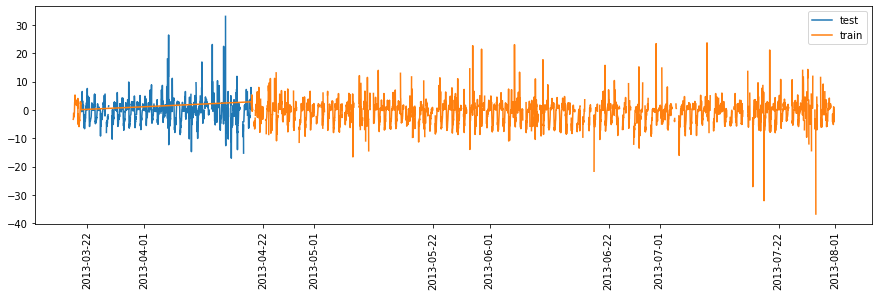

In [75]:
plt.figure(figsize=(15,4))
plt.plot(test_df_.DateTime, test_df_[yvar], label='test')
plt.plot(train_df_.DateTime, train_df_[yvar], label='train')
plt.xticks(rotation=90)
plt.legend()

In [76]:
full_df['Set_rank'].unique()

array(['layer1_subset2', 'layer2', 'layer1_subset4', 'layer1_subset3',
       'layer1_subset6', 'layer1_subset5', 'layer1_subset1', 'test'],
      dtype=object)

In [77]:
test_filter = (full_df['Set_rank']=='test')
train_filter = (full_df['Set_rank']!='test')

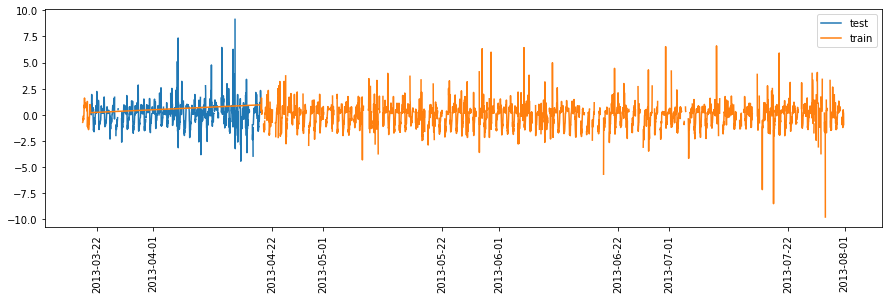

In [78]:
plt.figure(figsize=(15,4))
plt.plot(full_df.loc[test_filter, 'DateTime'], full_df.loc[test_filter, yvar], label='test')
plt.plot(full_df.loc[train_filter, 'DateTime'], full_df.loc[train_filter, yvar], label='train')
plt.xticks(rotation=90)
plt.legend()

In [79]:
assert train_df_.shape[0] + test_df_.shape[0] == full_df.shape[0]
assert full_df[full_df['Set_rank']!='test'].shape[0] + full_df[full_df['Set_rank']=='test'].shape[0] == full_df.shape[0]

In [80]:
full_df[(full_df['DateTime'] < '2013-04-22') & ~test_filter].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 958
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ta        959 non-null    float64       
 1   Ws        959 non-null    float64       
 2   Fg        959 non-null    float64       
 3   VPD       959 non-null    float64       
 4   Fn        959 non-null    float64       
 5   q         959 non-null    float64       
 6   Ts        959 non-null    float64       
 7   Sws       959 non-null    float64       
 8   EVI       959 non-null    float64       
 9   Set_rank  959 non-null    object        
 10  DateTime  959 non-null    datetime64[ns]
 11  Fc        144 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 97.4+ KB


In [81]:
train_df_[(train_df_['DateTime'] < '2013-04-22')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 2927 to 5326
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fc        144 non-null    float64       
 1   DateTime  959 non-null    datetime64[ns]
 2   Ta        959 non-null    float64       
 3   Ws        959 non-null    float64       
 4   Fg        959 non-null    float64       
 5   VPD       959 non-null    float64       
 6   Fn        959 non-null    float64       
 7   q         959 non-null    float64       
 8   Ts        959 non-null    float64       
 9   Sws       959 non-null    float64       
 10  EVI       959 non-null    float64       
 11  Set_rank  959 non-null    object        
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 97.4+ KB


In [84]:
Xtrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), Xvar]
ytrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), yvar]

X_test = full_df.loc[test_filter, Xvar]
y_test = full_df.loc[test_filter, yvar]

In [154]:
NSTEPS = 5
NFEATURES = Xtrain_bothlayers.shape[1]

# convert into input/output sequences
dataset_train = np.column_stack((Xtrain_bothlayers, ytrain_bothlayers))
dataset_trainX, dataset_trainy = utils.split_sequences(dataset_train, NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape)

# define model
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(NSTEPS, NFEATURES), activation='relu', 
                    dropout=0.5, recurrent_dropout=0.5))
model_lstm.add(Dense(1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history = model_lstm.fit(dataset_trainX, dataset_trainy,
                            validation_split=0.5, shuffle=False,
                            epochs=50, batch_size=16, verbose=2)

dataset_test = np.column_stack((X_test, y_test))
dataset_testX, dataset_testy = utils.split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model_lstm.predict(dataset_testX, verbose=0)

metric_lstm = utils.diagnostic_stats(dataset_testy*ystd + ymean,
                                     yhat_test.squeeze()*ystd + ymean)

yhat_test = np.concatenate((np.array([np.nan]*(NSTEPS-1)), yhat_test.squeeze()))

(3822, 5, 9) (3822,)
Train on 1911 samples, validate on 1911 samples
Epoch 1/50
 - 6s - loss: 1.0574 - val_loss: 1.0393
Epoch 2/50
 - 2s - loss: 0.8531 - val_loss: 0.9873
Epoch 3/50
 - 1s - loss: 0.8026 - val_loss: 0.9550
Epoch 4/50
 - 1s - loss: 0.7176 - val_loss: 0.9144
Epoch 5/50
 - 1s - loss: 0.6907 - val_loss: 0.8599
Epoch 6/50
 - 2s - loss: 0.6576 - val_loss: 0.7958
Epoch 7/50
 - 2s - loss: 0.6587 - val_loss: 0.7657
Epoch 8/50
 - 2s - loss: 0.6299 - val_loss: 0.7524
Epoch 9/50
 - 2s - loss: 0.6314 - val_loss: 0.7449
Epoch 10/50
 - 2s - loss: 0.6112 - val_loss: 0.7347
Epoch 11/50
 - 2s - loss: 0.6151 - val_loss: 0.7229
Epoch 12/50
 - 2s - loss: 0.6200 - val_loss: 0.7220
Epoch 13/50
 - 2s - loss: 0.5934 - val_loss: 0.7029
Epoch 14/50
 - 2s - loss: 0.5959 - val_loss: 0.6991
Epoch 15/50
 - 2s - loss: 0.5844 - val_loss: 0.6966
Epoch 16/50
 - 2s - loss: 0.5876 - val_loss: 0.6941
Epoch 17/50
 - 2s - loss: 0.5674 - val_loss: 0.6988
Epoch 18/50
 - 2s - loss: 0.6101 - val_loss: 0.6903
Epoc

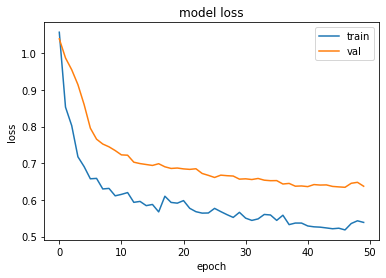

In [155]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

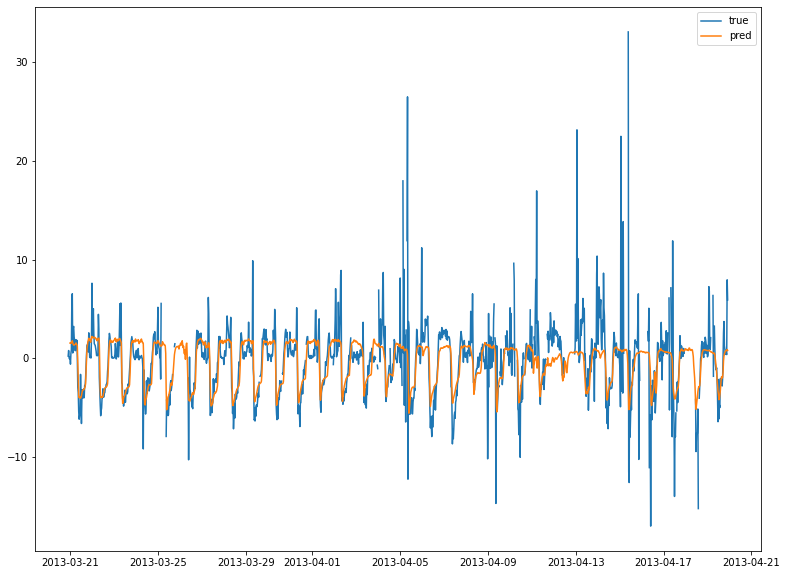

In [156]:
plt.figure(figsize=(13,10))
plt.plot(full_df.loc[test_filter, 'DateTime'], full_df.loc[test_filter, yvar]*ystd + ymean, label='true')
plt.plot(full_df.loc[test_filter, 'DateTime'], yhat_test*ystd + ymean, label='pred')
plt.legend()